## DeepONet for 1D-Burgers Equation

The 1D Burgers equation is a fundamental nonlinear PDE whose general form can be written as:
\begin{equation}
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}
with initial condition $u(x,0) = u_0(x)$, and boundary conditions that can be periodic, Dirichlet, or Neumann. Where:
* $u(x,t)$ is the velocity field,
* $x$ and $t$ are the spatial and temporal coordinates respectively,
* $\nu$ is a viscosity diffusion coefficient.

In the inviscid form($\nu = 0$), it models the  propagation of a wave, where the velocity $u(x,t)$ is both the amplitude (height) of the wave and the speed at which that part of the wave travels, such that each "piece" of the wave travels at a speed equal to its own height. Over time, the wave steepens, developing shocks or sharp discontinuities.

In [19]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim     #optimizer
from scipy.io import loadmat
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
import time
import copy

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
NVIDIA RTX A6000


### Configurations and data preparation

In [18]:
class config:
  def __init__(self):
    #The training parameters
    self.num_epoch = 50
    self.batch_size = 20

    #Optimizer
    self.lr = 0.001
    self.weight_decay = 1e-4  #Regularization weight

    #The learning rate scheduler
    self.step_size = 100  #To decay after every, say 100 epochs
    self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

    ##Model hyperparameters

    #Parameters for the dataset
    self.resolution_original = 8192 #Original spatial resolution
    self.sub_sample = 8    #Reduce the original resolution by a factor of 8, for faster training
    self.train_data_num = 1000   #Training samples
    self.test_data_num = 200      #Testing data samples

    #File paths (Specifying for kaggle)
    self.dataset_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/Scientific-Machine-Learning/dataset/burgers_data_R10.mat'
    self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/Scientific-Machine-Learning/dataset/deeponet_burgers_model.pt'
    self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/Scientific-Machine-Learning/dataset/checkpoint_deeponet'


cfg = config()

In [7]:
print(cfg.dataset_path)
print(cfg.model_path)
print(cfg.checkpoint_dir)

C:/Users/idris_oduola/Documents/Projects/RqPINN/Scientific-Machine-Learning/dataset/burgers_data_R10.mat
C:/Users/idris_oduola/Documents/Projects/RqPINN/Scientific-Machine-Learning/dataset/deeponet_burgers_model.pt
C:/Users/idris_oduola/Documents/Projects/RqPINN/Scientific-Machine-Learning/dataset/checkpoint_deeponet


##### Visualizing the data

In [8]:
burgers_data = loadmat(cfg.dataset_path)

In [ ]:
keys_list = [key for key in burgers_data]
print(f"There are {len(keys_list[3:])} keys in the dataset")  #Remove metadata
for i, key_list in enumerate(keys_list[3:]):
    print(f"No. {i+1}: key {key_list} is of type {type(burgers_data[key_list])} and of shape {burgers_data[key_list].shape}")

There are 5 keys in the dataset
No. 1: key a is of type <class 'numpy.ndarray'> and of shape (2048, 8192)
No. 2: key a_smooth is of type <class 'numpy.ndarray'> and of shape (2048, 8192)
No. 3: key a_smooth_x is of type <class 'numpy.ndarray'> and of shape (2048, 8191)
No. 4: key a_x is of type <class 'numpy.ndarray'> and of shape (2048, 8191)
No. 5: key u is of type <class 'numpy.ndarray'> and of shape (2048, 8192)


From the above, key "a" contains the initials conditions (input) $u_0 = u(x,0)$. While key "u" contains the final velocities at time t = 1.  

It can be seen data there are $2048$ samples, and the spatial resolution is $8192$. We are going to subsample to $1024$ points and assume the domain is $[0,1]$.

But first, we will  visualize some of the initial and final velocities in the data.

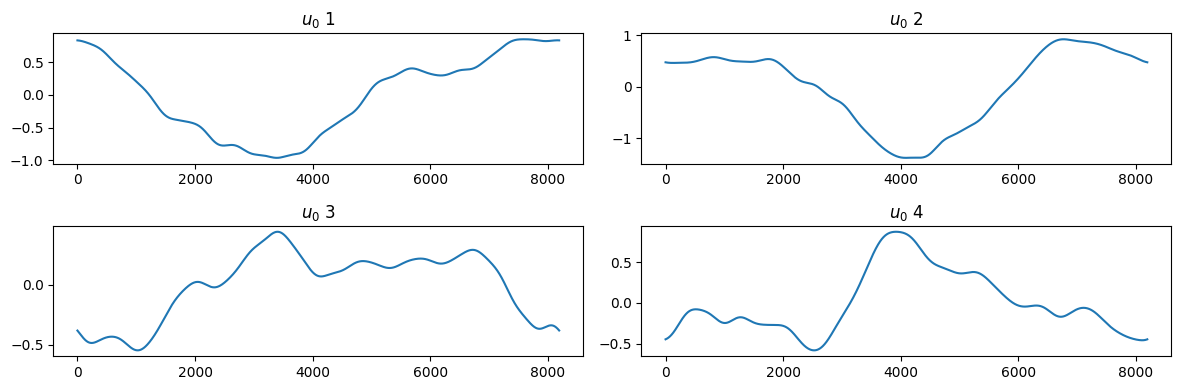

In [16]:
u0 = burgers_data[keys_list[3]]
plt.figure(figsize = (12,4))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(u0[i], label = f"Initial condition {i+1}")
    plt.title(f"$u_0$ {i+1}")
plt.tight_layout()
plt.show()

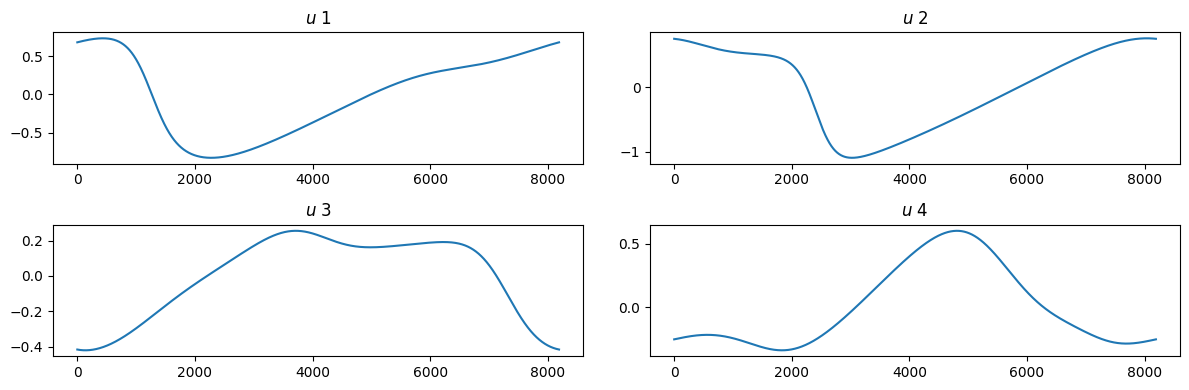

In [17]:
u = burgers_data[keys_list[-1]]
plt.figure(figsize = (12,4))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(u[i], label = f"final prediction {i+1}")
    plt.title(f"$u$ {i+1}")
plt.tight_layout()
plt.show()

##### Data Preparation

In [ ]:
def prepare_data(raw_data, cfg, include_coord = True):
    #First we extract and downsample our input and output data
    branch_input_data = torch.tensor(raw_data['a'], dtype = torch.float)[:,::cfg.sub_sample]   #shape: (batch, Nx)
    target_data = torch.tensor(raw_data['u'], dtype = torch.float)[:,::cfg.sub_sample]  #shape: (batch, Nx)
    #We need to assert that the shape matches our expectation
    expected_resolution = cfg.resolution_original//cfg.sub_sample
    assert branch_input_data.shape[1] == expected_resolution, f"Expected downsized sample {expected_resolution}, but got {branch_input_data.shape[1]}"
    print(f'For the downsampled dataset --> input: {branch_input_data.shape}, target: {target_data.shape}')
    print(f"branch_input_data dtype: {branch_input_data.dtype}, target_data dtype: {target_data.dtype}")
      
    #Next we split the downsampled dataset into training and testing
    dataset = TensorDataset(branch_input_data, target_data)
    branch_train_set, test_set = random_split(dataset, [cfg.train_data_num, cfg.test_data_num])
    

    #We need to reshape the data: (batch, N) --> (batch, N, 1), and then add grid information to ensure positional awareness

    x_train = x_train.unsqueeze(-1); x_test = x_test.unsqueeze(-1); y_train = y_train.unsqueeze(-1); y_test = y_test.unsqueeze(-1)
    print(f"After reshaping --> y_train: {y_train.shape}, y_test: {y_test.shape}")

    if include_coord: #To add the positional (grid) information
        grid = torch.linspace(0,1, cfg.resolution_original, dtype = torch.float).view(-1,1)
        grid = grid[::cfg.sub_sample]
        x_train = torch.cat([x_train, grid.repeat(cfg.train_data_num, 1, 1)], dim = 2)
        x_test = torch.cat([x_test, grid.repeat(cfg.test_data_num, 1, 1)], dim = 2)
        print(f"After adding the grid --> x_train: {x_train.shape}, x_test: {x_test.shape}")

    #Creating the dataloader
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=cfg.batch_size, shuffle=False)
    
    return train_loader, test_loader